In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import expipe
import os
import neo
import pathlib
import numpy as np
import elephant as el
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq

09:57:44 [I] klustakwik KlustaKwik2 version 0.2.6


In [2]:
par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

binsize = par['spat_binsize']
smoothing = 0.03
plt.rcParams['figure.figsize'] = (16,9)

In [3]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
action_id = "1833-200619-1"
channel_id = 0

action  = actions[action_id]

data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

x, y, t, speed = dp.load_tracking(data_path, par)



In [5]:
def make_spike_lfp_coherence(data_path, channel_id, t_start, t_stop, f_start, f_stop):
    t_start = t_start * pq.s
    t_stop = t_stop * pq.s
    
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=False)
    
    anas = dp.load_lfp(data_path, channel_id)
    
    sampling_rate = anas.sampling_rate.magnitude
    
    times = np.arange(0, anas.shape[0] / sampling_rate, 1 / sampling_rate) * pq.s
    
    mask = (times > t_start) & (times < t_stop)
    
    times = times[mask]
    
    ana_arr = np.array(anas)[mask,:]
    
    anas = neo.AnalogSignal(
        signal=ana_arr * anas.units, sampling_rate=anas.sampling_rate, t_start=t_start,
        **anas.annotations    
    )
    
    chs = anas.annotations['electrode_idx']
    
    for u, sptr in enumerate(spike_trains):
        sptr = neo.SpikeTrain(
            sptr.times[(sptr.times > t_start) & (sptr.times < times[-1])],
            t_start=t_start, t_stop=times[-1],
            **sptr.annotations
        )
        
        sigs, freqs = el.sta.spike_field_coherence(anas, sptr, **{'nperseg': 2048})
        fig, axs = plt.subplots(1, 3)
        fig.suptitle('channel group {} {}'.format(
            sptr.annotations['group_id'], sptr.name))
        for sig, ch in zip(sigs.T, chs):
            axs[0].plot(freqs, sig, label='ch {}'.format(ch))
        axs[0].legend()
        axs[0].set_xlim(f_start, f_stop)
        axs[0].set_title('coherence')

        for ana, ch in zip(anas.T, chs):
            axs[1].psd(ana, Fs=sampling_rate, NFFT=2048)
        axs[1].set_xlim(f_start, f_stop)
        axs[1].set_title('lfp psd')

        bins = np.arange(
            sptr.t_start.magnitude, sptr.t_stop.magnitude, 1 / sampling_rate) #time bins for spikes
        #firing rate histogram
        hist = np.histogram(sptr, bins=bins)[0].astype(float)
        hist -= hist.mean()
        axs[2].psd(hist, Fs=sampling_rate, NFFT=2048)
        axs[2].set_xlim(f_start, f_stop)
        axs[2].set_title('spike psd')


In [8]:
t_start, t_stop = 140, 250

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/signal/spectral.py:1578: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7007: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


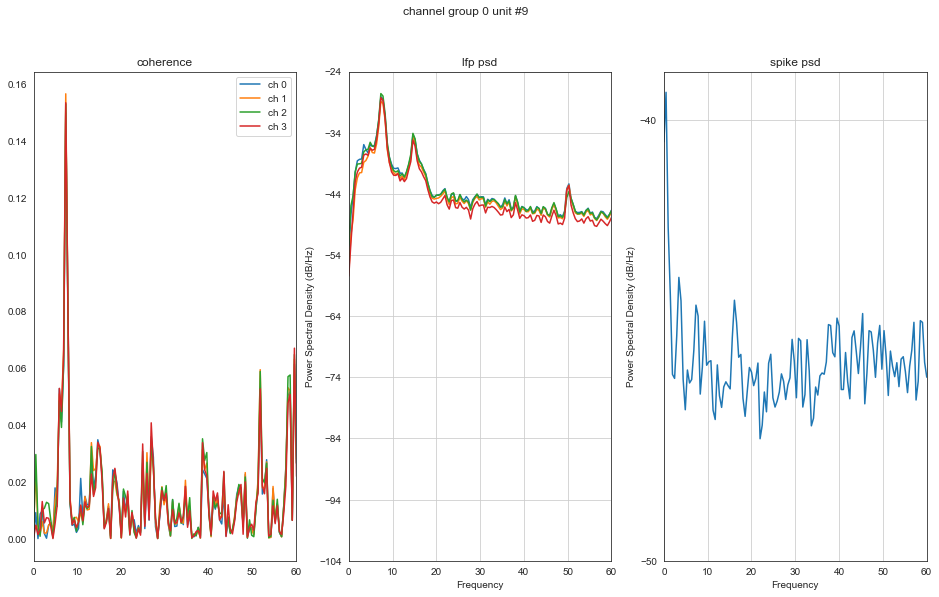

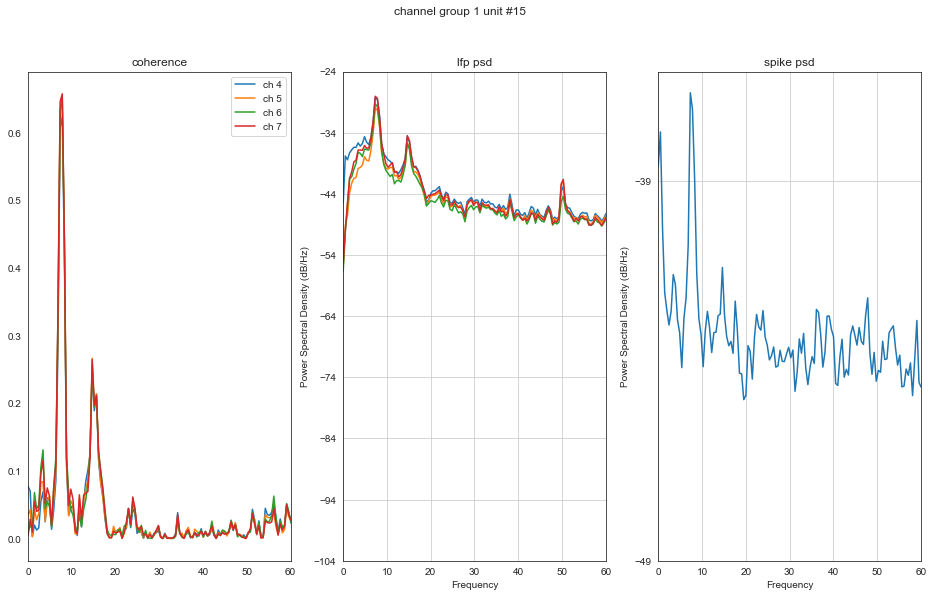

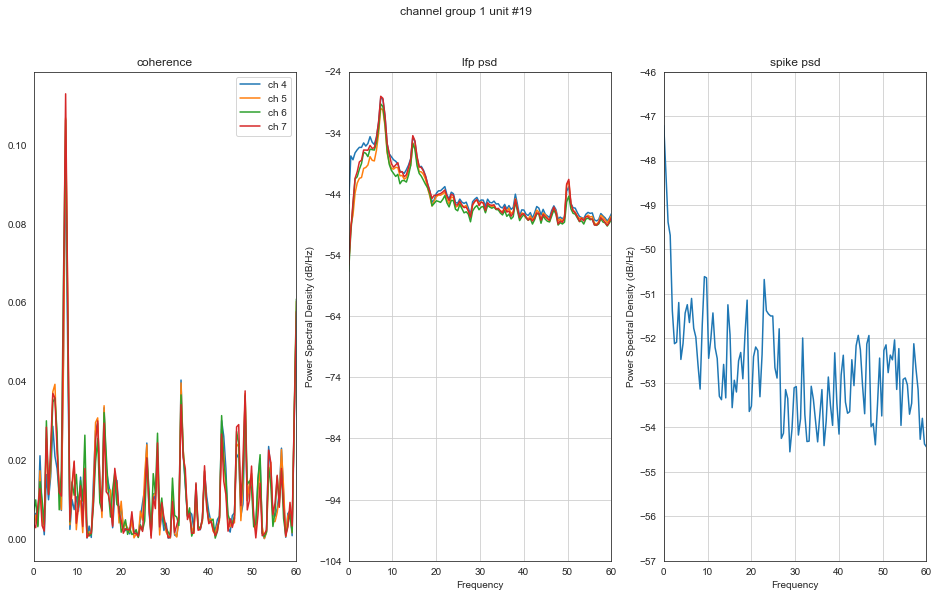

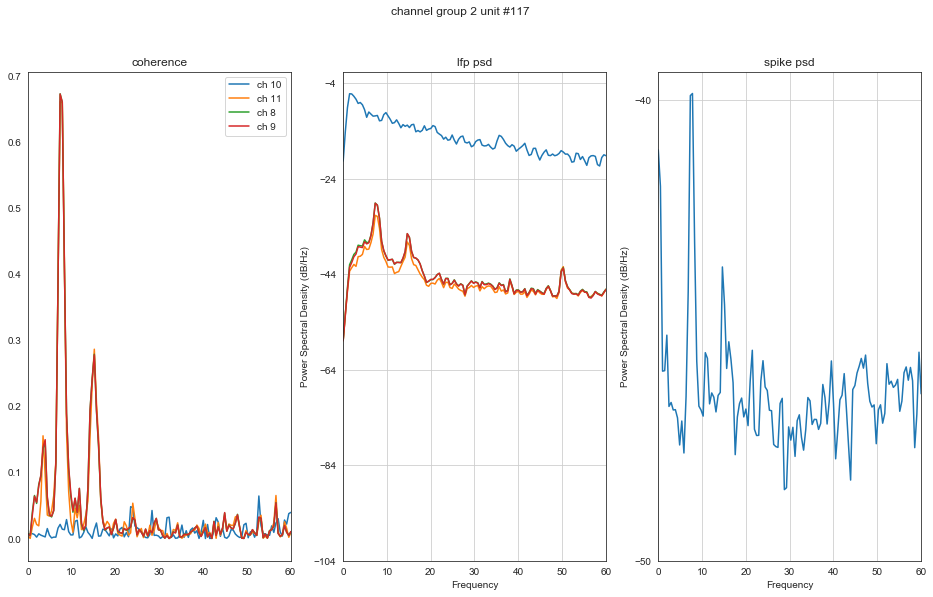

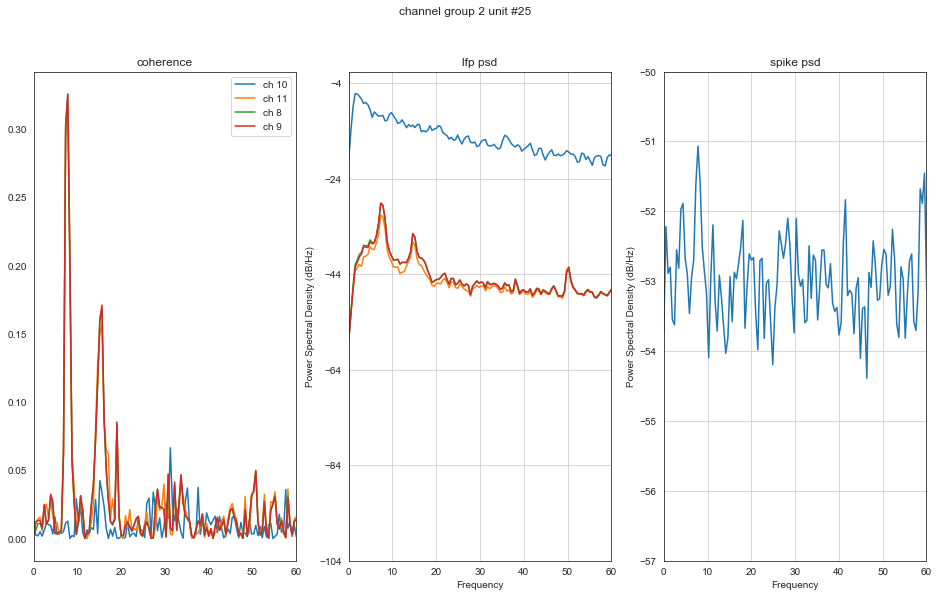

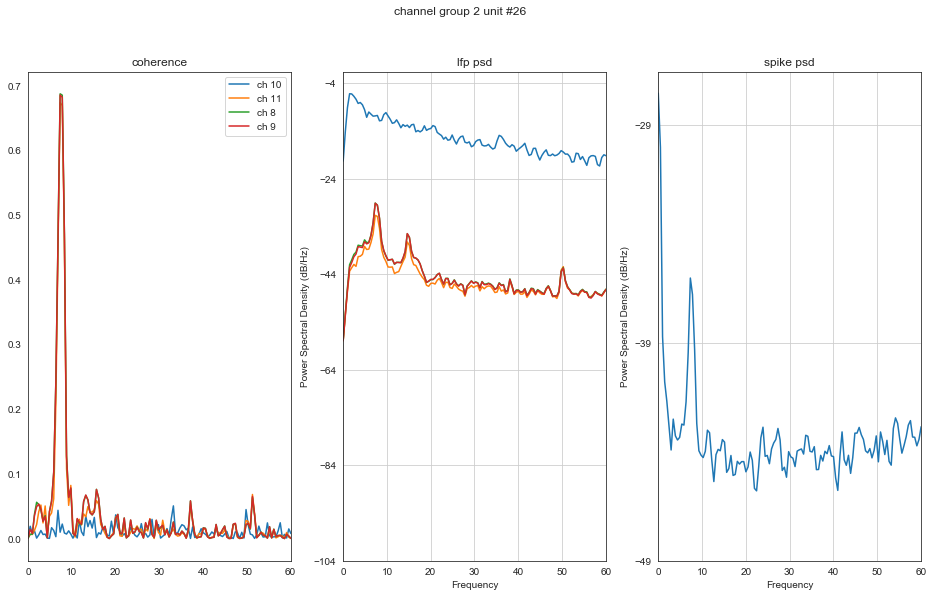

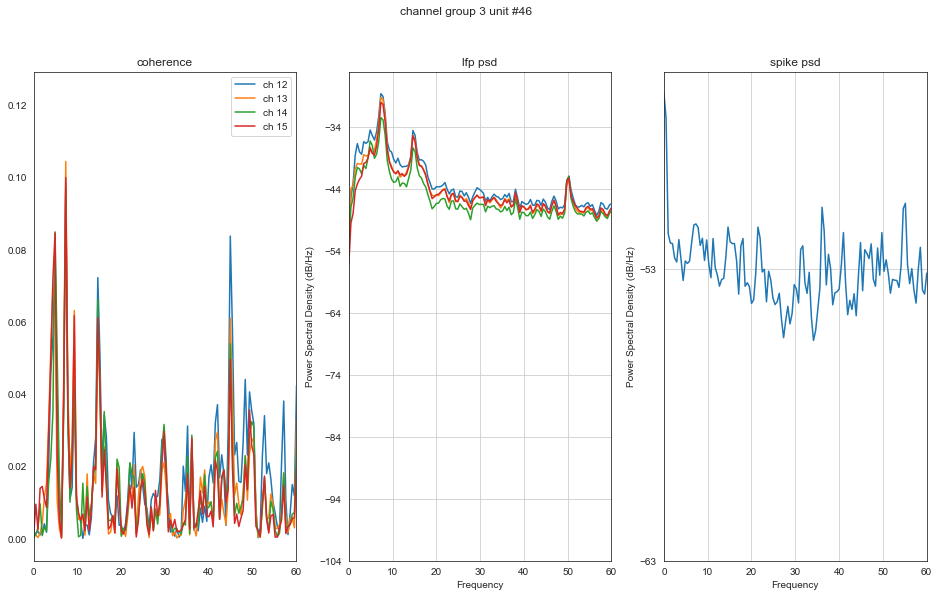

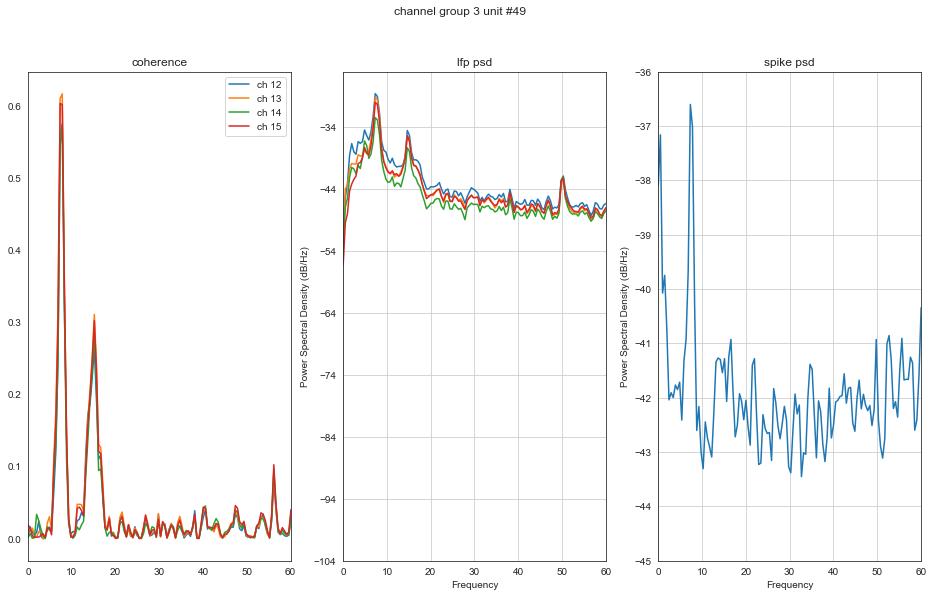

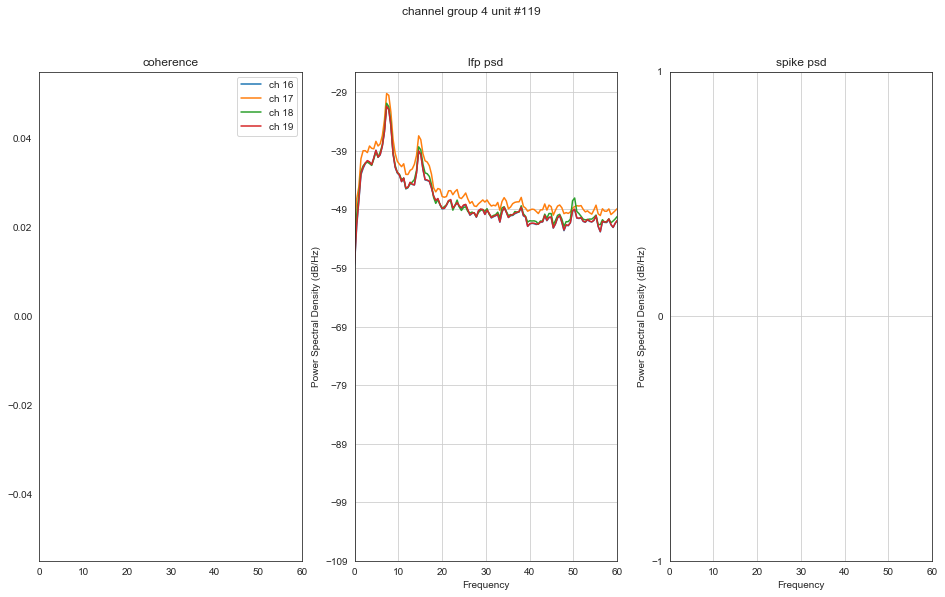

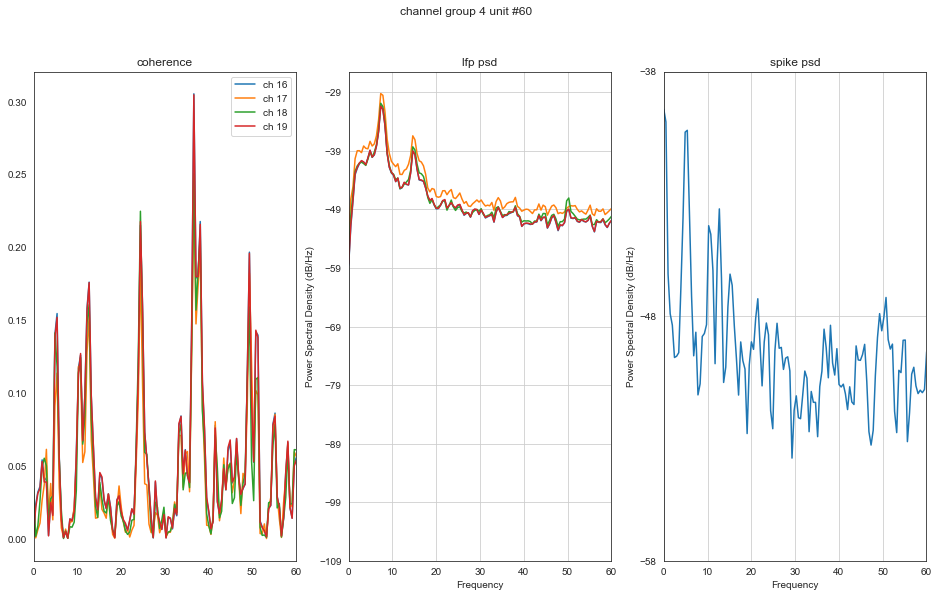

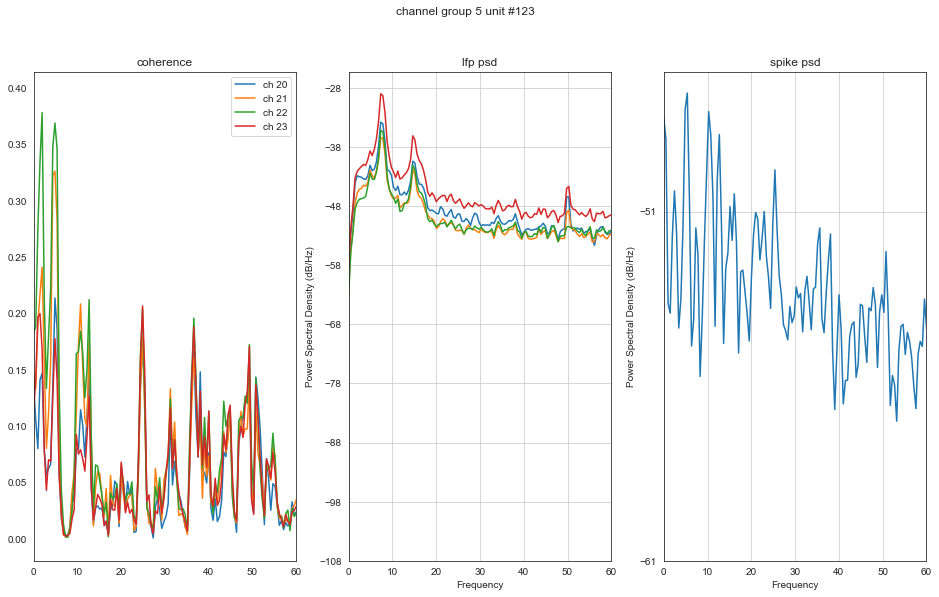

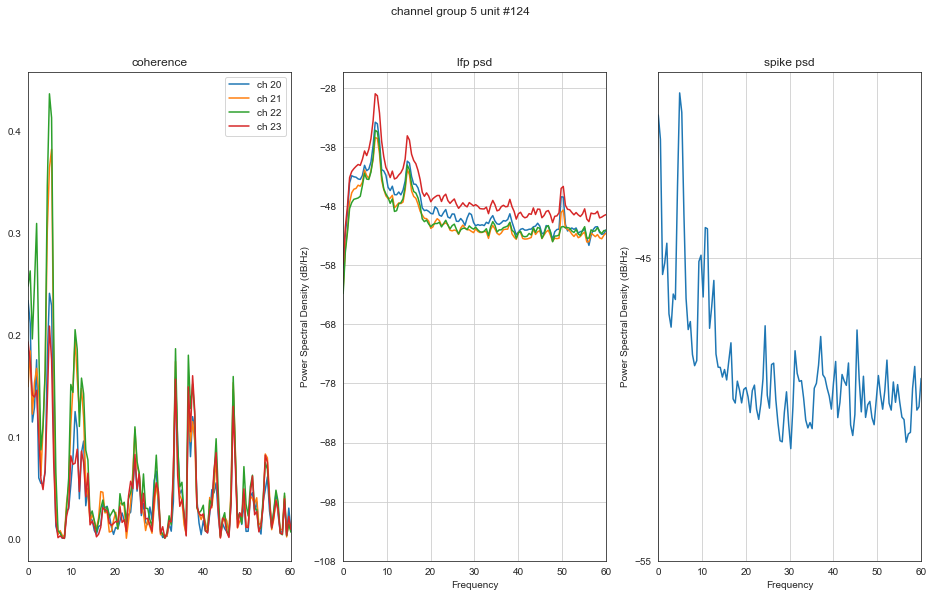

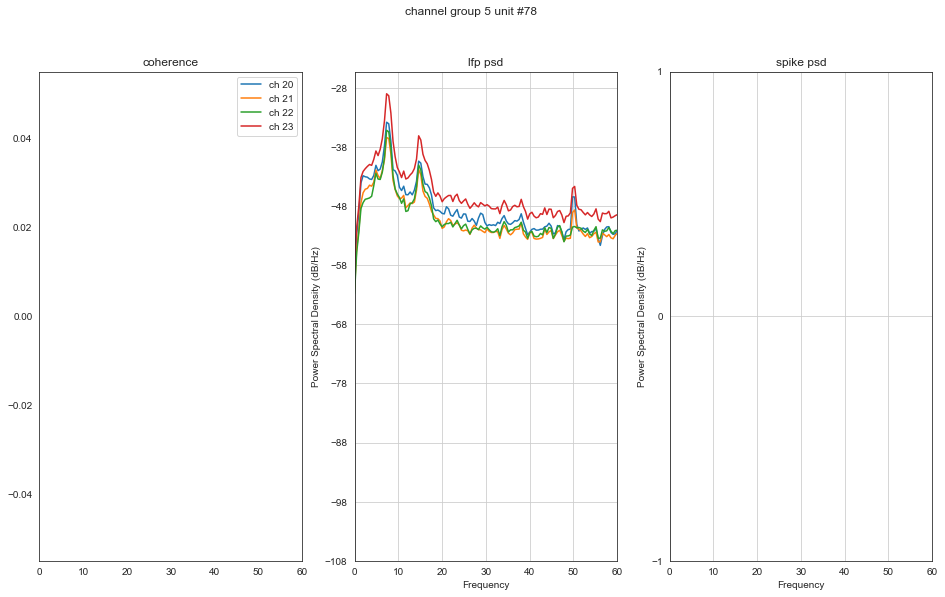

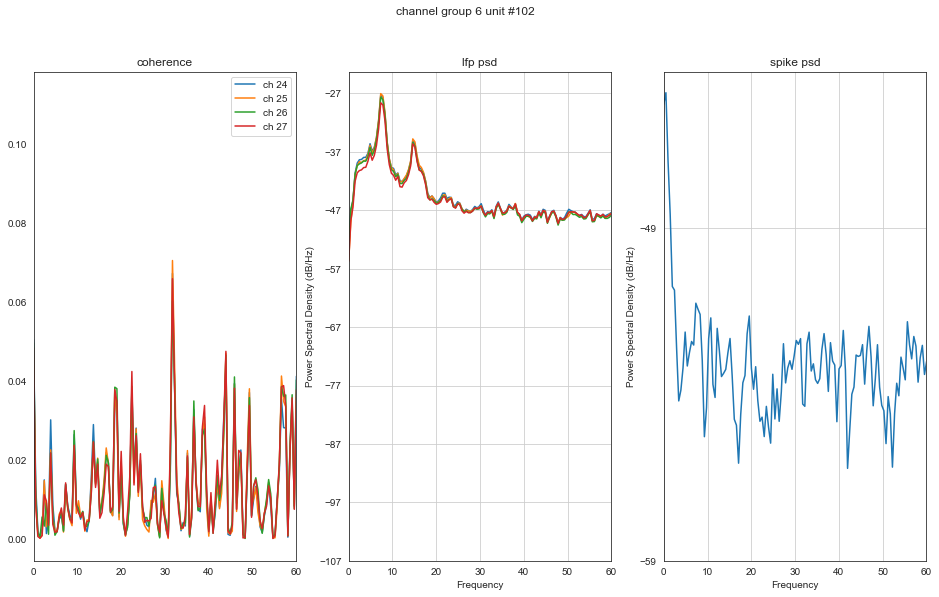

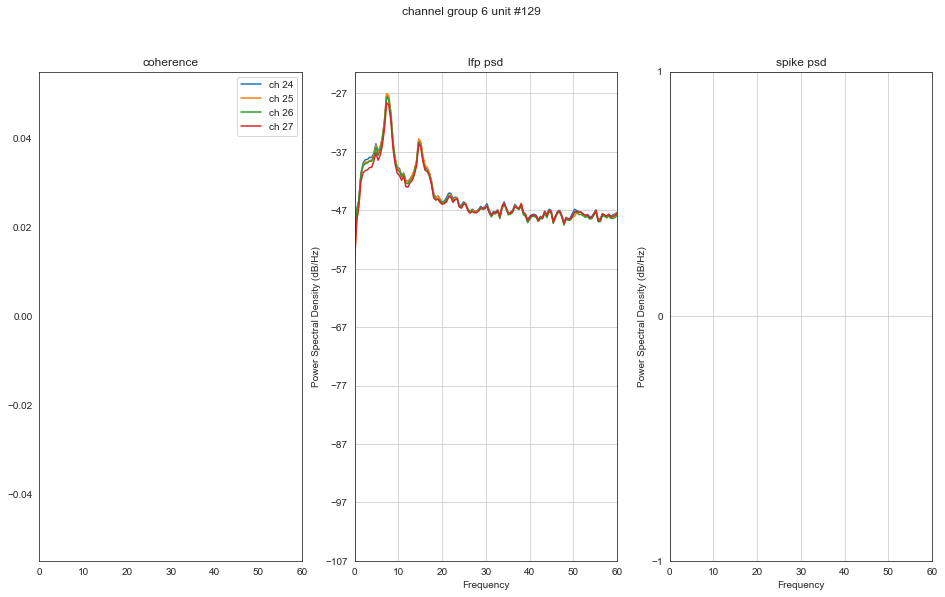

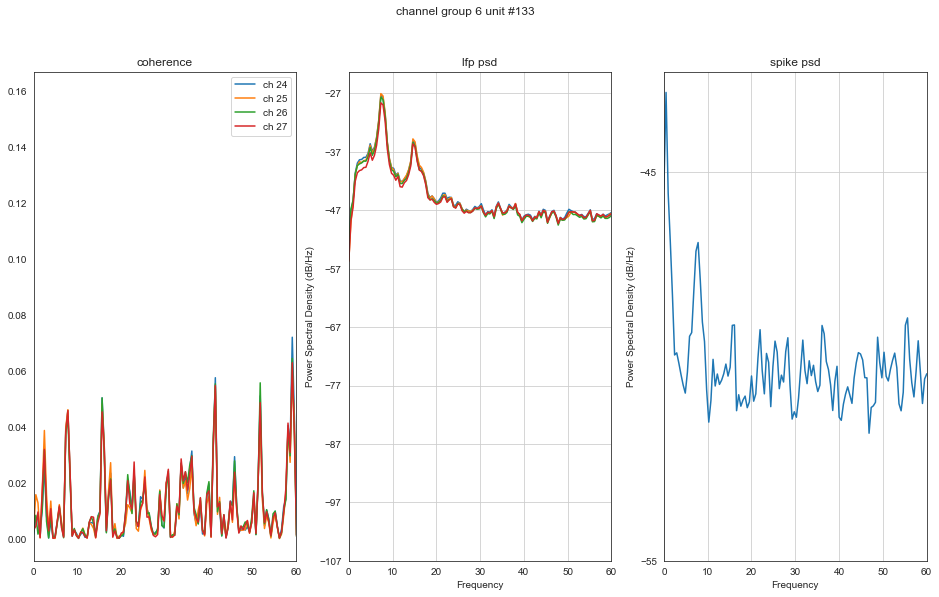

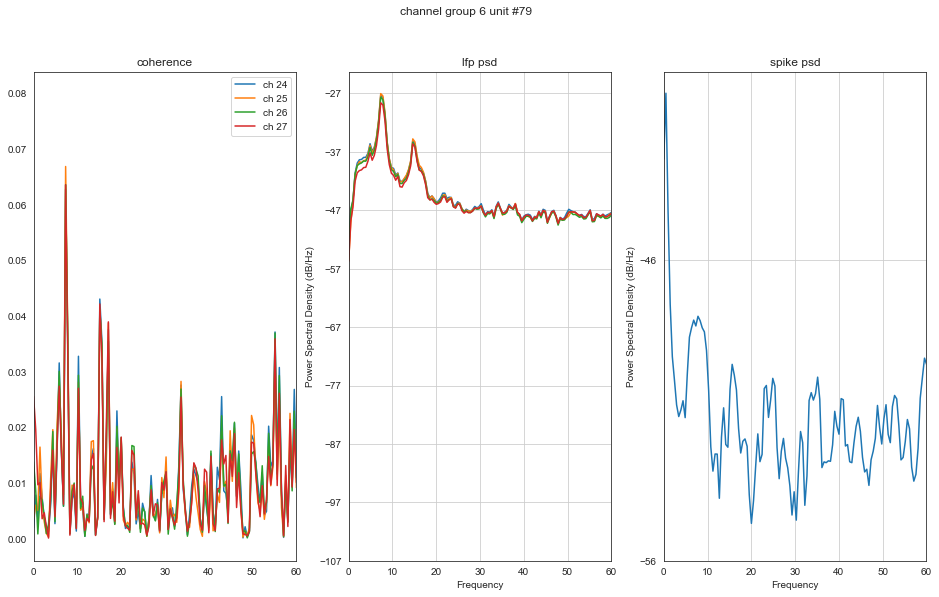

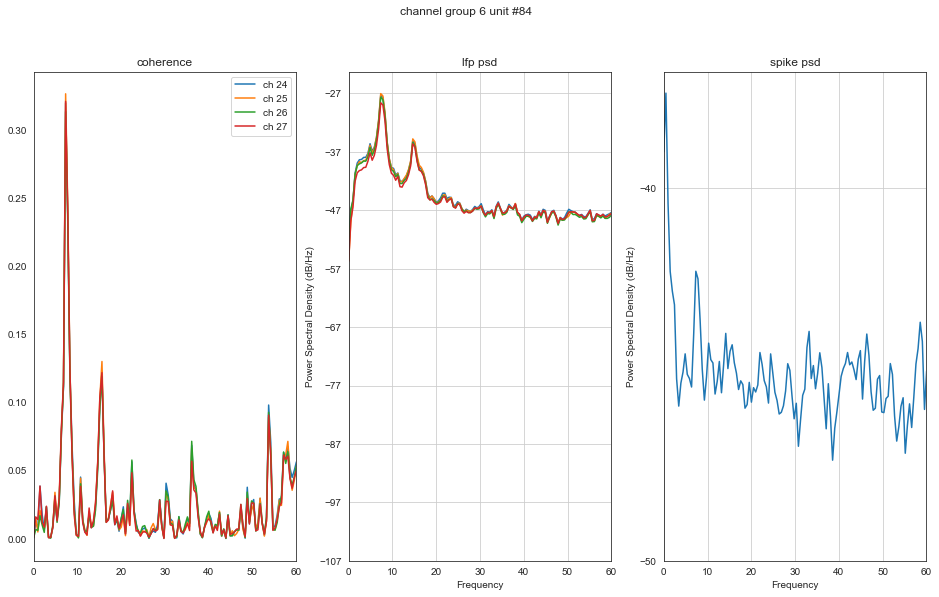

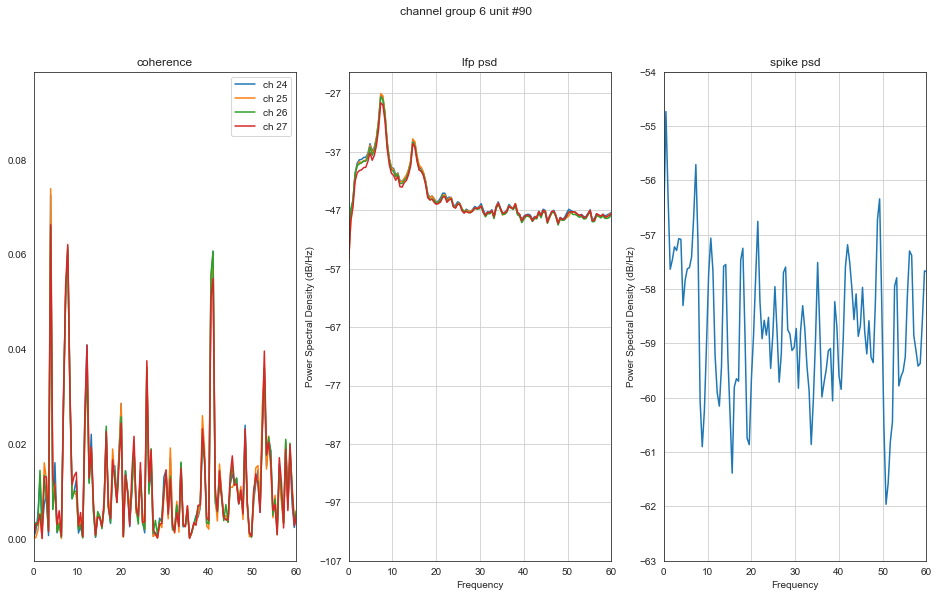

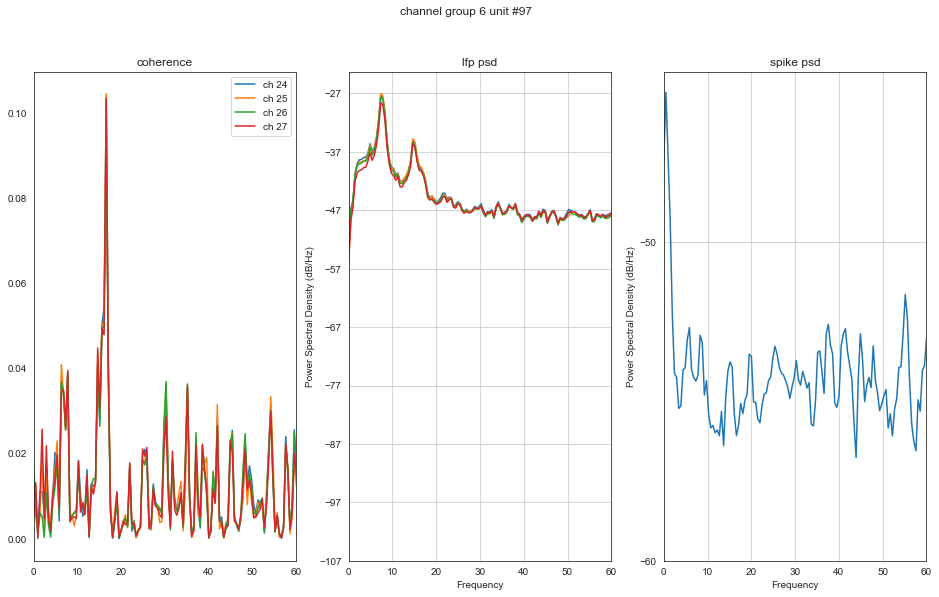

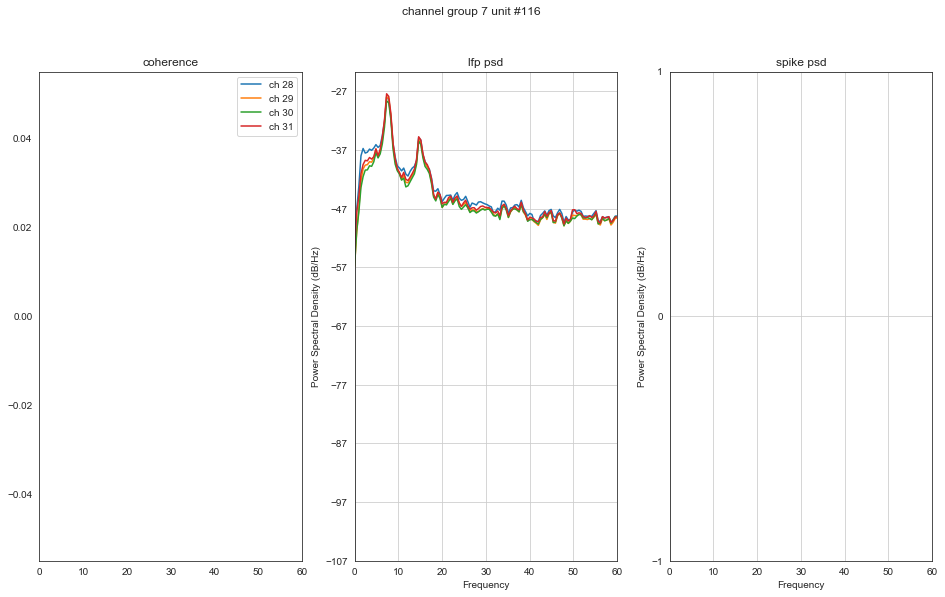

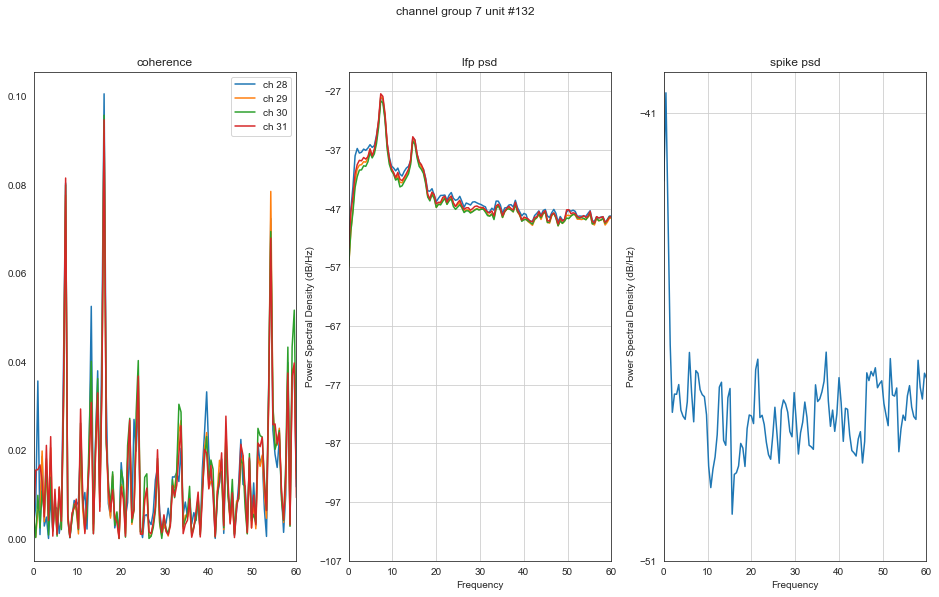

In [10]:
for channel_id in range(8):
    make_spike_lfp_coherence(data_path, channel_id, t_start, t_stop, 0, 60)

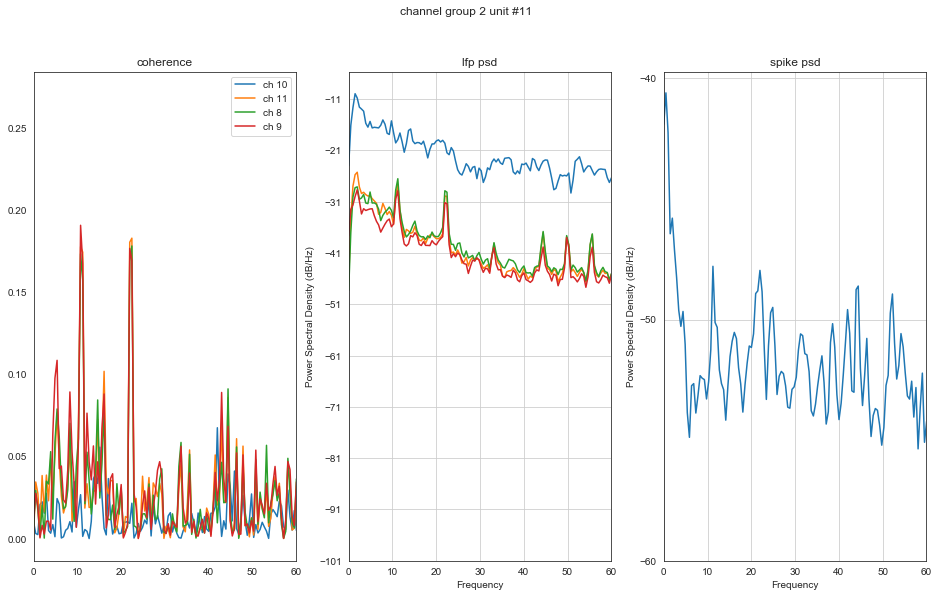

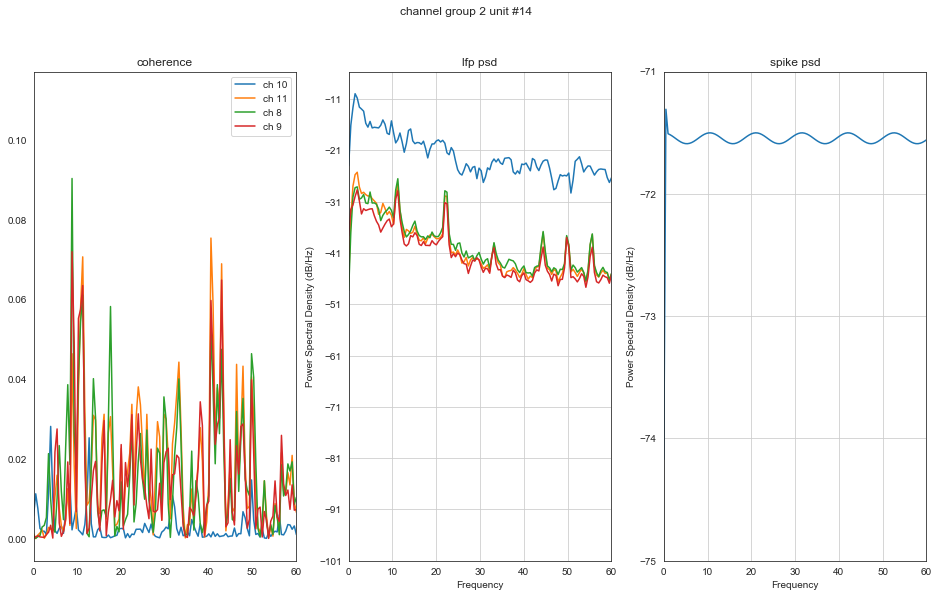

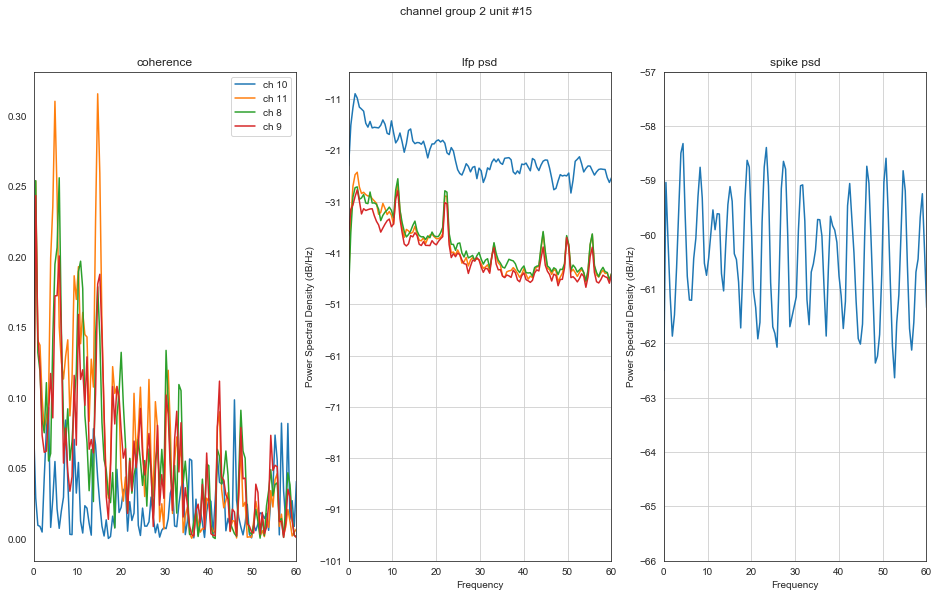

In [19]:
make_spike_lfp_coherence(data_path, channel_id, 100, 160, 0, 60)